In [1]:
%reload_ext cairo_jupyter

ImageSurface


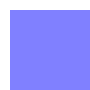

SVG to buffer


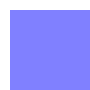

continue drawing...
Display final surface
Canvas display as bitmap


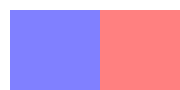

Canvas display svg


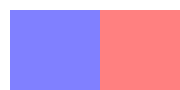

In [4]:
import cairo

from contextlib import contextmanager
from io import BytesIO
from pathlib import Path

from IPython.display import display

FORMAT_PS = 'ps'
FORMAT_PDF = 'pdf'
FORMAT_PNG = 'png'
FORMAT_SVG = 'svg'
FORMAT_SVG_XML = 'svg_xml'

VALID_FORMATS = [FORMAT_PNG, FORMAT_SVG, FORMAT_SVG_XML]

ERROR_UNSUPPORTED_FORMAT = "Format must be FORMAT_PDF, FORMAT_PNG, FORMAT_PS, FORMAT_SVG or FORMAT_SVG_XML"

class BufferedCanvas:
    """
    Uses a RecordingSurface to keep track of the draw state on the current frame/page,
    and allowing it to be copied to various outputs as needed.
    """
    def __init__(self, extents=None):
        """
        :param dimensions: Extents of recording surface, or None for unbounded.
        """
        self.surface = cairo.RecordingSurface(cairo.CONTENT_COLOR_ALPHA, extents) 
    
    def copy_to_surface(self, f, surface):
        # Draw self.surface onto another surface
        cr = cairo.Context(surface)
        cr.set_source_surface(self.surface)
        cr.paint()
        del cr

    def save(self, f, format=None, *args, **kwargs):
        """
        Output current canvas frame, using cairo to save.
        
        :param f: buffer or filename.
        """
        if not format:
            if isinstance(f, str):
                suffix = Path(f).suffix
                format = suffix.rsplit('.')[-1] or FORMAT_PNG
            else:
                format = FORMAT_PNG
        
        extents = self.surface.ink_extents()  # TODO: handle ink_extents that don't start at 0, 0
        dimensions = extents[2], extents[3]
        if format == FORMAT_PNG:
            # PNG is special: write_to_png is called after drawing.
            surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, int(dimensions[0]), int(dimensions[1]))
            self.copy_to_surface(f, surface)
            surface.write_to_png(f)
            return
        elif format == FORMAT_PDF:
            surface = cairo.PDFSurface(f, *dimensions)
        elif format == FORMAT_PS:
            surface = cairo.PDFSurface(f, *dimensions)
        elif format in (FORMAT_SVG, FORMAT_SVG_XML):
            surface = cairo.SVGSurface(f, *dimensions)
        else:
            raise ValueError(ERROR_UNSUPPORTED_FORMAT)
            
        self.copy_to_surface(f, surface)
        surface.flush()  # Ensure data written to file or buffer.

    def display(self, format=FORMAT_PNG, *args, **kwargs):
        """
        """
        from IPython.display import Image, SVG, display as _display

        if format in (FORMAT_PDF, FORMAT_PS):
            raise NotImplementedError(f"{format} is not yet supported.")
        
        with BytesIO() as io:
            self.save(io, format)
            if format == FORMAT_PNG:
                _display(Image(data=io.getvalue()))
            elif format == FORMAT_SVG:
                _display(SVG(io.getvalue()))
            elif format == FORMAT_SVG_XML:
                try:
                    from display_xml import XML
                except ImportError:
                    raise ImportError('Install display_xml to output as XML:  $ pip3 install display_xml')

                _display(XML(io.getvalue()))
            else:
                # Included for completeness, should have been caught by the call to save().
                raise ValueError(ERROR_UNSUPPORTED_FORMAT)
    
    @contextmanager
    def committable_surface(self):
        surface = RecordingSurface(cairo.CONTENT_COLOR_ALPHA, None)
        try:
            yield surface
        except Exception as e:
            print("exc: e")
        else:
            print("no exception")
        

      
class AnimationState:
    def __init__(self, speed = None):
        self.speed = speed
    
    def is_animation(self):
        return self.speed is None


class ShoebotRunner:
    def __init__(self):
        self.canvas = BufferedCanvas()
    
    def run_once(self, code):
        # During first frame canvas is already cleared.
        
        # ?
        # with canvas.page():
        #    blah
        #    blah
        
        # During subsequent frames if canvas should be cleared use show_page, otherwise copy_page
        # for outputs.
        with self.canvas.committable_surface() as surface:
            print("hello")
    
    def run_multiple(self, code):
        pass
    
    def run(self):
        pass

# Draw on surface
canvas = BufferedCanvas()
ctx = cairo.Context(canvas.surface)
ctx.set_source_rgb(.5, .5, 1.)
ctx.rectangle(10, 10, 90, 90)
ctx.fill()

# intermediate ImageSurface 1
print("ImageSurface")
canvas.display(format=FORMAT_PNG, dimensions=(128, 128))

# intermediate SVGSurface to buffer
print("SVG to buffer")
canvas.display(format=FORMAT_SVG)
canvas.display(format=FORMAT_SVG_XML)


# continue drawing
print("continue drawing...")
ctx.set_source_rgb(1., .5, .5)
ctx.rectangle(100, 10, 90, 90)
ctx.fill()

del ctx

print("Display final surface")

canvas.surface.ink_extents()

print("Canvas display as bitmap")
canvas.display(FORMAT_PNG, dimensions=(180, 40))

print("Canvas display svg")
canvas.display(FORMAT_SVG)